<h1>Asan Dopollos Model</h1>

------
# Imports
------

In [282]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


# Import datasets
network = pd.read_csv('network.csv')
inspections = pd.read_csv('inspections.csv')
pipes = pd.read_csv('sample_submission.csv')
weather = pd.read_csv('temperature.csv')

-----
# Data Visualization
-----

In [283]:
network.head()

,PipeId,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,489616,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.0,7.792,0.4,0,0,False
1,489645,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,90.0,2.080,0.4,0,0,False
2,489646,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,90.0,111.173,0.4,3,0,False
3,519950,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,200.0,14.304,0.4,0,0,False
4,1332439,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,160.0,22.669,0.4,1,0,False


In [284]:
pipes.head()

,PipeId,Incidence
0,446859944,0
1,428124500,0
2,438428871,0
3,429034569,0
4,411184477,0


In [285]:
inspections.head()

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,0
1,188889914,ZRV-00001406,2010,2010-10-01,22,4,0
2,188889907,ZRV-00001406,2010,2010-10-01,22,4,0
3,188673355,ZRV-00001406,2010,2010-10-01,22,4,0
4,188558922,ZRV-00001406,2010,2010-10-01,22,4,0


## External data processing

In [286]:
weather = weather.drop(['datetime','tempmax','tempmin', 'temp', 'humidity', 'solarradiation', 'uvindex'],axis=1)
# drop duplicates
weather = weather.drop_duplicates()
# Change value type
weather['max_temp_year'] = weather['max_temp_year'].astype('float')
weather['min_temp_year'] = weather['min_temp_year'].astype('float')
weather['avg_temp_year'] = weather['avg_temp_year'].astype('float')
weather['avg_humid_year'] = weather['avg_humid_year'].astype('float')

weather.head()

,Province,InspectionYear,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year
0,León,2010,33.1,-12.0,10.032055,72.990685
365,León,2011,33.0,-11.0,11.165479,71.784110
730,León,2012,34.2,-10.0,10.470219,68.450546
1096,León,2013,35.8,-9.0,10.120548,73.955890
1461,León,2014,33.4,-8.8,10.956986,72.493151


## Dataframe merging

Merging the df with an inner join using PipeId

In [287]:
# Merge dataframes
main_df = inspections.merge(
                        network,
                        how = 'inner',
                        on=['PipeId'] 
                        )

main_df

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.000,0,0,False
1,189311802,ZRV-00001972,2012,2012-10-01,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.000,0,0,False
2,189311802,ZRV-00001972,2014,2014-10-08,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.000,0,0,False
3,189311802,ZRV-00001972,2016,2016-10-14,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.000,0,0,False
4,189311802,ZRV-00001972,2018,2018-10-09,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.000,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345339,56922448,ZRV-00004581,2020,2020-12-31,24,4,0,Valencia,Betera,1993,PE,Gas natural,63.0,1.237,4.000,0,0,False
6345340,56907425,ZRV-00004581,2020,2020-12-31,24,4,0,Valencia,Betera,2000,PE,Gas natural,160.0,169.732,4.000,1,0,False
6345341,7843615,ZRV-00002112,2021,2020-12-31,24,4,0,Barcelona,Sabadell,1995,FD,Gas natural,150.0,0.361,0.025,0,0,True
6345342,56922456,ZRV-00004581,2020,2020-12-31,24,4,0,Valencia,Betera,1993,PE,Gas natural,63.0,23.306,4.000,0,0,False


| Field               | Meaning                                              |
|---------------------|------------------------------------------------------|
| PipeId              | Unique identifier for the pipe                       |
| Province            | Spanish province where the pipe is located           |
| Town                | Town or city where the pipe is located               |
| YearBuilt           | Year in which the pipe was built and installed       |
| Material            | Material in which the pipe is built                  | 
| GasType             | Type of gas that runs through the pipe               |
| Diameter            | Diameter of the pipe (in mm)                         |
| Length              | Length of the pipe (in m)                            |
| Pressure            | Pressure of the gas that runs through the pipe (bar) |
| NumConnections      | Number of connections (external)                     |
| NumConnectionsUnder | Number of connections (internal and buried)          |
| BoolBridle          | Whether the pipe is bridled (True) or welded (False) |



## Split

In [288]:
# df, X_test, y_train, y_test = train_test_split(main_df.drop(['Incidence'],axis=1),main_df['Incidence'])

In [289]:
# df['Incidence'] = y_train
# X_test['Incidence'] = y_test

Dates will be converted to datetime.

In [290]:
main_df['InspectionDate'] = pd.to_datetime(main_df['InspectionDate'])
main_df = main_df.sort_values(['InspectionDate'])

Temporal split

In [291]:
df = main_df.iloc[:5000000]
X_test = main_df.iloc[5000000:]

----
# Data preparation
----

Column Dop: MaintenaceId, Town, NumConnectionsUnder

In [292]:
df = df.drop(['MaintenanceId','NumConnectionsUnder','Town'],axis=1)
df

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle
0,189311802,2010,2010-10-01,24,4,0,Barcelona,2001,PE,Gas natural,160.0,117.831,4.000,0,False
6322,188527341,2010,2010-10-01,24,4,0,Barcelona,1998,PE,Gas natural,110.0,88.085,0.025,12,False
6328,329280193,2010,2010-10-01,24,4,0,Alicante,2001,PE,Gas natural,200.0,2.530,0.150,0,False
6334,188524801,2010,2010-10-01,24,4,0,Barcelona,1998,PE,Gas natural,110.0,7.817,0.025,0,False
6340,188524794,2010,2010-10-01,24,4,0,Barcelona,1998,PE,Gas natural,160.0,12.205,0.025,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695314,189856607,2019,2019-01-03,24,4,0,Barcelona,1968,AO,Gas natural,152.4,1.512,4.000,0,True
6079142,21603953,2019,2019-01-03,24,4,0,Córdoba,2015,PE,Gas natural,90.0,20.074,0.150,1,False
695319,189856613,2019,2019-01-03,24,4,0,Barcelona,2001,AO,Gas natural,152.4,61.761,4.000,0,True
722009,332092069,2019,2019-01-03,24,4,0,Alicante,2008,PE,Gas natural,110.0,2.383,0.150,0,False


In [293]:
X_test = X_test.drop(['MaintenanceId','NumConnectionsUnder','Town'],axis=1)
X_test

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle
1668003,190951671,2019,2019-01-03,24,4,0,Tarragona,2004,PE,Gas natural,63.0,5.700,0.150,0,False
2684830,52183439,2018,2019-01-03,24,4,0,Madrid,2002,PE,Gas natural,110.0,2.686,0.025,1,False
2684836,52186245,2018,2019-01-03,24,4,0,Madrid,2002,PE,Gas natural,110.0,2.984,0.025,1,False
2543292,58822836,2019,2019-01-03,22,4,0,Madrid,2003,PE,Gas natural,315.0,75.298,0.025,0,False
629065,132933046,2019,2019-01-03,25,4,0,Valladolid,1994,PE,Gas natural,63.0,38.000,4.000,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4773846,373408526,2020,2020-12-31,23,4,0,Valencia,2010,PE,Gas natural,63.0,33.873,4.000,0,False
4772935,420929111,2020,2020-12-31,23,4,0,Valencia,2011,PE,Gas natural,110.0,2.120,4.000,0,False
4772931,420931416,2020,2020-12-31,23,4,0,Valencia,2011,PE,Gas natural,110.0,3.360,4.000,0,False
4772648,420928983,2020,2020-12-31,23,4,0,Valencia,2011,PE,Gas natural,160.0,2.654,4.000,0,False


Severity values will be inverted, meaning that they will go from 0-3 going from no incidence to highest severity

In [294]:
inverse_sev = {4:0,3:1,2:2,1:3}
list = []
for sev in df["Severity"]:
    list.append(inverse_sev[sev]) 

df['Severity'] = list
df

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle
0,189311802,2010,2010-10-01,24,0,0,Barcelona,2001,PE,Gas natural,160.0,117.831,4.000,0,False
6322,188527341,2010,2010-10-01,24,0,0,Barcelona,1998,PE,Gas natural,110.0,88.085,0.025,12,False
6328,329280193,2010,2010-10-01,24,0,0,Alicante,2001,PE,Gas natural,200.0,2.530,0.150,0,False
6334,188524801,2010,2010-10-01,24,0,0,Barcelona,1998,PE,Gas natural,110.0,7.817,0.025,0,False
6340,188524794,2010,2010-10-01,24,0,0,Barcelona,1998,PE,Gas natural,160.0,12.205,0.025,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695314,189856607,2019,2019-01-03,24,0,0,Barcelona,1968,AO,Gas natural,152.4,1.512,4.000,0,True
6079142,21603953,2019,2019-01-03,24,0,0,Córdoba,2015,PE,Gas natural,90.0,20.074,0.150,1,False
695319,189856613,2019,2019-01-03,24,0,0,Barcelona,2001,AO,Gas natural,152.4,61.761,4.000,0,True
722009,332092069,2019,2019-01-03,24,0,0,Alicante,2008,PE,Gas natural,110.0,2.383,0.150,0,False


In [295]:
inverse_sev = {4:0,3:1,2:2,1:3}
list = []
for sev in X_test["Severity"]:
    list.append(inverse_sev[sev]) 

X_test['Severity'] = list
X_test

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle
1668003,190951671,2019,2019-01-03,24,0,0,Tarragona,2004,PE,Gas natural,63.0,5.700,0.150,0,False
2684830,52183439,2018,2019-01-03,24,0,0,Madrid,2002,PE,Gas natural,110.0,2.686,0.025,1,False
2684836,52186245,2018,2019-01-03,24,0,0,Madrid,2002,PE,Gas natural,110.0,2.984,0.025,1,False
2543292,58822836,2019,2019-01-03,22,0,0,Madrid,2003,PE,Gas natural,315.0,75.298,0.025,0,False
629065,132933046,2019,2019-01-03,25,0,0,Valladolid,1994,PE,Gas natural,63.0,38.000,4.000,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4773846,373408526,2020,2020-12-31,23,0,0,Valencia,2010,PE,Gas natural,63.0,33.873,4.000,0,False
4772935,420929111,2020,2020-12-31,23,0,0,Valencia,2011,PE,Gas natural,110.0,2.120,4.000,0,False
4772931,420931416,2020,2020-12-31,23,0,0,Valencia,2011,PE,Gas natural,110.0,3.360,4.000,0,False
4772648,420928983,2020,2020-12-31,23,0,0,Valencia,2011,PE,Gas natural,160.0,2.654,4.000,0,False


-----
# Feature Engineering
-----

## Material properties
Table with the material type:

|Material Type | Corrodes | Young's Module (GPa) |
|--------------|----------|----------------------|
|AO: aluminum oxide     | No     |  380 |
|CU: copper     | Yes     | 120 |
|FD: ductil function     | No     |  172 |
|FG: fiber glass     | No     | 50 |
|FI: flame inhibitant     | No     | 4 |
|FO: unkown     | No     | 4 |
|PA: polyamid     | No     | 6 |
|PE: polyehtylene     | No     | 1 | 
|PN: polyethylene naphthalate     | No     | 4.5 |
|PV: polyvinyl      | No     | 4 | 
|ZD: zinc diecasting     | No     | 100 |

In [296]:
# Adding corrosive properties to the elements
df ['Corrosive'] = 0
indices = df[df.Material == 'CU'].index
df['Corrosive'][indices] = 1
# Adding Youngs Modulus to see which ones are more prone to cracks
youngs_dict = {'AO':380,'CU':120,'FD':172,'FG':50,'FI':4,'FO':4,'PA':6,'PE':1,'PN':4.5,'PV':4,'ZD':100}
lst = []
for idx in df.index:
    lst.append(youngs_dict[df['Material'][idx]])

df['Youngs_Mod'] = lst
df

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_40248/4004144257.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Corrosive'][indices] = 1


,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod
0,189311802,2010,2010-10-01,24,0,0,Barcelona,2001,PE,Gas natural,160.0,117.831,4.000,0,False,0,1.0
6322,188527341,2010,2010-10-01,24,0,0,Barcelona,1998,PE,Gas natural,110.0,88.085,0.025,12,False,0,1.0
6328,329280193,2010,2010-10-01,24,0,0,Alicante,2001,PE,Gas natural,200.0,2.530,0.150,0,False,0,1.0
6334,188524801,2010,2010-10-01,24,0,0,Barcelona,1998,PE,Gas natural,110.0,7.817,0.025,0,False,0,1.0
6340,188524794,2010,2010-10-01,24,0,0,Barcelona,1998,PE,Gas natural,160.0,12.205,0.025,0,False,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695314,189856607,2019,2019-01-03,24,0,0,Barcelona,1968,AO,Gas natural,152.4,1.512,4.000,0,True,0,380.0
6079142,21603953,2019,2019-01-03,24,0,0,Córdoba,2015,PE,Gas natural,90.0,20.074,0.150,1,False,0,1.0
695319,189856613,2019,2019-01-03,24,0,0,Barcelona,2001,AO,Gas natural,152.4,61.761,4.000,0,True,0,380.0
722009,332092069,2019,2019-01-03,24,0,0,Alicante,2008,PE,Gas natural,110.0,2.383,0.150,0,False,0,1.0


In [297]:
# Adding corrosive properties to the elements
X_test ['Corrosive'] = 0
indices = X_test[X_test.Material == 'CU'].index
X_test['Corrosive'][indices] = 1
# Adding Youngs Modulus to see which ones are more prone to cracks
youngs_dict = {'AO':380,'CU':120,'FD':172,'FG':50,'FI':4,'FO':4,'PA':6,'PE':1,'PN':4.5,'PV':4,'ZD':100}
lst = []
for idx in X_test.index:
    lst.append(youngs_dict[X_test['Material'][idx]])

X_test['Youngs_Mod'] = lst
X_test

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_40248/1263609729.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Corrosive'][indices] = 1


,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod
1668003,190951671,2019,2019-01-03,24,0,0,Tarragona,2004,PE,Gas natural,63.0,5.700,0.150,0,False,0,1.0
2684830,52183439,2018,2019-01-03,24,0,0,Madrid,2002,PE,Gas natural,110.0,2.686,0.025,1,False,0,1.0
2684836,52186245,2018,2019-01-03,24,0,0,Madrid,2002,PE,Gas natural,110.0,2.984,0.025,1,False,0,1.0
2543292,58822836,2019,2019-01-03,22,0,0,Madrid,2003,PE,Gas natural,315.0,75.298,0.025,0,False,0,1.0
629065,132933046,2019,2019-01-03,25,0,0,Valladolid,1994,PE,Gas natural,63.0,38.000,4.000,0,False,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4773846,373408526,2020,2020-12-31,23,0,0,Valencia,2010,PE,Gas natural,63.0,33.873,4.000,0,False,0,1.0
4772935,420929111,2020,2020-12-31,23,0,0,Valencia,2011,PE,Gas natural,110.0,2.120,4.000,0,False,0,1.0
4772931,420931416,2020,2020-12-31,23,0,0,Valencia,2011,PE,Gas natural,110.0,3.360,4.000,0,False,0,1.0
4772648,420928983,2020,2020-12-31,23,0,0,Valencia,2011,PE,Gas natural,160.0,2.654,4.000,0,False,0,1.0


## Value Normalization

In [298]:
for column in ['Diameter', 'Length', 'Pressure', 'Youngs_Mod']:
   df[column] = (df[column] - df[column].mean()) / df[column].std()
   X_test[column] = (X_test[column] - X_test[column].mean()) / X_test[column].std()

## Age of the pipe

In [299]:
df['Age'] = df["InspectionYear"] - df["YearBuilt"]

X_test['Age'] = X_test["InspectionYear"] - X_test["YearBuilt"]

## Severity of the previous inspection

In [300]:
main_df = pd.concat([df.iloc[:], X_test.iloc[:]])
main_df = main_df.sort_values(['PipeId','InspectionDate'])
main_df = main_df.reset_index(drop=True)

prev_sev = 0
previous_severity = []

for ind in main_df.index:
    previous_severity.append(prev_sev)
    prev_sev = main_df['Severity'][ind]

main_df['PrevSeverity'] = previous_severity

# Change first instance of the values
idx = main_df.loc[main_df.groupby('PipeId').cumcount() == 0]['PrevSeverity'].index
main_df['PrevSeverity'][idx] = 0

main_df

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_40248/3372920501.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['PrevSeverity'][idx] = 0


,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,Age,PrevSeverity
0,489616,2013,2013-05-08,16,0,0,Ciudad Real,2012,PE,Gas natural,-1.008093,-0.404134,-0.381603,0,False,0,-0.355651,1,0
1,489616,2015,2015-03-04,22,0,0,Ciudad Real,2012,PE,Gas natural,-1.008093,-0.404134,-0.381603,0,False,0,-0.355651,3,0
2,489616,2016,2017-01-12,22,0,0,Ciudad Real,2012,PE,Gas natural,-1.008093,-0.404134,-0.381603,0,False,0,-0.355651,4,0
3,489616,2018,2018-12-19,23,0,0,Ciudad Real,2012,PE,Gas natural,-1.008093,-0.404134,-0.381603,0,False,0,-0.355651,6,0
4,489616,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,-0.918310,-0.381848,-0.380359,0,False,0,-0.348499,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345339,451995260,2019,2019-10-23,24,0,0,Lleida,2003,PE,Gas natural,-0.450398,0.368231,-0.418665,2,False,0,-0.348499,16,0
6345340,451995309,2013,2013-10-07,24,0,0,Lleida,1998,PE,Gas natural,1.393561,0.800605,-0.419569,0,False,0,-0.355651,15,0
6345341,451995309,2015,2015-10-05,24,0,0,Lleida,1998,PE,Gas natural,1.393561,0.800605,-0.419569,0,False,0,-0.355651,17,0
6345342,451995309,2017,2017-10-02,24,0,0,Lleida,1998,PE,Gas natural,1.393561,0.800605,-0.419569,0,False,0,-0.355651,19,0


In [301]:
df = df.merge(main_df[['PipeId', 'InspectionDate', 'PrevSeverity']], on=['PipeId', 'InspectionDate'], how='left')
X_test = X_test.merge(main_df[['PipeId', 'InspectionDate', 'PrevSeverity']], on=['PipeId', 'InspectionDate'], how='left')

## Seismic activity

The accumulated number of seisms in total and between revisions will be used. Firstly the dataframe is loaded and a merge_asof is done

In [302]:
df_seism = pd.read_csv('Sismic_activity_dataframe.csv')
# Seism dates to datetimes
df_seism['Fecha'] = pd.to_datetime(df_seism['Fecha'])
# Merging using the closest date to the df
df = pd.merge_asof(df.sort_values(by='InspectionDate'),df_seism.sort_values(by='Fecha')
            ,left_on=['InspectionDate'],right_on=['Fecha'],by='Province')

# Order the rows
df = df.sort_values(['PipeId','InspectionDate'])

In [303]:
# Merging using the closest date to the X_test
X_test = pd.merge_asof(X_test.sort_values(by='InspectionDate'),df_seism.sort_values(by='Fecha')
            ,left_on=['InspectionDate'],right_on=['Fecha'],by='Province')

# Order the rows
X_test = X_test.sort_values(['PipeId','InspectionDate'])

Now, the acumulated variables are obtained

In [304]:
# Order the rows
df = df.drop(['Fecha','Year','Seism'],axis=1)
# Taking the difference bewteen elements of the same column
df['AcumSeismRev'] = df['AcumSeism'].diff()
df = df.fillna(value=0)
df = df.sort_values(['PipeId','InspectionDate'])

idx = df.loc[df.groupby('PipeId').cumcount() == 0]['AcumSeismRev'].index 
df['AcumSeismRev'][idx] = 0


df = df.reset_index(drop=True)
df

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_40248/1936198396.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AcumSeismRev'][idx] = 0


,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,...,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,Age,PrevSeverity,AcumSeism,AcumSeismRev
0,489616,2013,2013-05-08,16,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.404134,-0.381603,0,False,0,-0.355651,1,0,62.0,0.0
1,489616,2015,2015-03-04,22,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.404134,-0.381603,0,False,0,-0.355651,3,0,96.0,34.0
2,489616,2016,2017-01-12,22,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.404134,-0.381603,0,False,0,-0.355651,4,0,139.0,43.0
3,489616,2018,2018-12-19,23,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.404134,-0.381603,0,False,0,-0.355651,6,0,159.0,20.0
4,489645,2013,2013-05-08,16,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.485641,-0.381603,0,False,0,-0.355651,1,0,62.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,451995260,2015,2015-09-28,23,0,0,Lleida,2003,PE,Gas natural,...,0.444782,-0.419569,2,False,0,-0.355651,12,0,650.0,267.0
4999996,451995260,2017,2017-10-02,25,0,0,Lleida,2003,PE,Gas natural,...,0.444782,-0.419569,2,False,0,-0.355651,14,0,1324.0,674.0
4999997,451995309,2013,2013-10-07,24,0,0,Lleida,1998,PE,Gas natural,...,0.800605,-0.419569,0,False,0,-0.355651,15,0,383.0,0.0
4999998,451995309,2015,2015-10-05,24,0,0,Lleida,1998,PE,Gas natural,...,0.800605,-0.419569,0,False,0,-0.355651,17,0,650.0,267.0


In [305]:
# Order the rows
X_test = X_test.drop(['Fecha','Year','Seism'],axis=1)
# Taking the difference bewteen elements of the same column
X_test['AcumSeismRev'] = X_test['AcumSeism'].diff()
X_test = X_test.fillna(value=0)
X_test = X_test.sort_values(['PipeId','InspectionDate'])

idx = X_test.loc[X_test.groupby('PipeId').cumcount() == 0]['AcumSeismRev'].index 
X_test['AcumSeismRev'][idx] = 0


X_test = X_test.reset_index(drop=True)
X_test

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_40248/2101468222.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['AcumSeismRev'][idx] = 0


,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,...,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,Age,PrevSeverity,AcumSeism,AcumSeismRev
0,489616,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.381848,-0.380359,0,False,0,-0.348499,8,0,206.0,0.0
1,489645,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.453866,-0.380359,0,False,0,-0.348499,8,0,206.0,0.0
2,489646,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,0.921586,-0.380359,3,False,0,-0.348499,8,0,206.0,0.0
3,489780,2020,2020-04-18,24,0,0,Toledo,2009,PE,Gas natural,...,-0.385719,0.324463,0,False,0,-0.348499,11,0,57.0,0.0
4,489790,2020,2020-04-18,24,0,0,Toledo,2012,PE,Gas natural,...,-0.424161,0.171241,0,False,0,-0.348499,8,0,57.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345341,451195391,2019,2019-01-03,24,0,0,Málaga,2012,PE,Gas natural,...,-0.432432,-0.418665,0,False,0,-0.348499,7,0,1375.0,0.0
1345342,451195430,2019,2019-01-03,24,0,0,Málaga,2012,PE,Gas natural,...,1.170482,-0.418665,7,False,0,-0.348499,7,0,1375.0,0.0
1345343,451995254,2019,2019-10-24,48,0,0,Lleida,2010,PE,Gas natural,...,-0.478905,-0.418665,0,False,0,-0.348499,9,0,1992.0,0.0
1345344,451995260,2019,2019-10-23,24,0,0,Lleida,2003,PE,Gas natural,...,0.368231,-0.418665,2,False,0,-0.348499,16,0,1991.0,0.0


## Weather data

In [306]:
df = df.merge(
                        weather,
                        how = 'left',
                        on=['Province', 'InspectionYear'] 
                        )

df

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,...,Corrosive,Youngs_Mod,Age,PrevSeverity,AcumSeism,AcumSeismRev,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year
0,489616,2013,2013-05-08,16,0,0,Ciudad Real,2012,PE,Gas natural,...,0,-0.355651,1,0,62.0,0.0,40.1,-7.0,14.015616,66.045753
1,489616,2015,2015-03-04,22,0,0,Ciudad Real,2012,PE,Gas natural,...,0,-0.355651,3,0,96.0,34.0,41.0,-6.0,15.870411,58.847397
2,489616,2016,2017-01-12,22,0,0,Ciudad Real,2012,PE,Gas natural,...,0,-0.355651,4,0,139.0,43.0,39.3,-4.0,16.173224,61.136066
3,489616,2018,2018-12-19,23,0,0,Ciudad Real,2012,PE,Gas natural,...,0,-0.355651,6,0,159.0,20.0,39.8,-5.2,15.277260,63.517808
4,489645,2013,2013-05-08,16,0,0,Ciudad Real,2012,PE,Gas natural,...,0,-0.355651,1,0,62.0,0.0,40.1,-7.0,14.015616,66.045753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,451995260,2015,2015-09-28,23,0,0,Lleida,2003,PE,Gas natural,...,0,-0.355651,12,0,650.0,267.0,42.3,-4.1,15.577808,69.311507
4999996,451995260,2017,2017-10-02,25,0,0,Lleida,2003,PE,Gas natural,...,0,-0.355651,14,0,1324.0,674.0,39.6,-6.9,15.325479,67.676164
4999997,451995309,2013,2013-10-07,24,0,0,Lleida,1998,PE,Gas natural,...,0,-0.355651,15,0,383.0,0.0,35.8,-3.4,15.430959,70.917534
4999998,451995309,2015,2015-10-05,24,0,0,Lleida,1998,PE,Gas natural,...,0,-0.355651,17,0,650.0,267.0,42.3,-4.1,15.577808,69.311507


In [307]:
X_test = X_test.merge(
                        weather,
                        how = 'left',
                        on=['Province', 'InspectionYear'] 
                        )

X_test

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,...,Corrosive,Youngs_Mod,Age,PrevSeverity,AcumSeism,AcumSeismRev,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year
0,489616,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,0,-0.348499,8,0,206.0,0.0,40.9,-4.1,16.164754,62.295628
1,489645,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,0,-0.348499,8,0,206.0,0.0,40.9,-4.1,16.164754,62.295628
2,489646,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,0,-0.348499,8,0,206.0,0.0,40.9,-4.1,16.164754,62.295628
3,489780,2020,2020-04-18,24,0,0,Toledo,2009,PE,Gas natural,...,0,-0.348499,11,0,57.0,0.0,42.1,-3.1,16.707377,61.272404
4,489790,2020,2020-04-18,24,0,0,Toledo,2012,PE,Gas natural,...,0,-0.348499,8,0,57.0,0.0,42.1,-3.1,16.707377,61.272404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345341,451195391,2019,2019-01-03,24,0,0,Málaga,2012,PE,Gas natural,...,0,-0.348499,7,0,1375.0,0.0,39.4,1.8,19.208493,63.754795
1345342,451195430,2019,2019-01-03,24,0,0,Málaga,2012,PE,Gas natural,...,0,-0.348499,7,0,1375.0,0.0,39.4,1.8,19.208493,63.754795
1345343,451995254,2019,2019-10-24,48,0,0,Lleida,2010,PE,Gas natural,...,0,-0.348499,9,0,1992.0,0.0,40.7,-4.4,15.496438,65.074521
1345344,451995260,2019,2019-10-23,24,0,0,Lleida,2003,PE,Gas natural,...,0,-0.348499,16,0,1991.0,0.0,40.7,-4.4,15.496438,65.074521


In [308]:
for column in ['max_temp_year', 'min_temp_year', 'avg_temp_year', 'avg_humid_year']:
   df[column] = (df[column] - df[column].mean()) / df[column].std()
   X_test[column] = (X_test[column] - X_test[column].mean()) / X_test[column].std()

## Accumulated Incidences and Revisions

In [309]:
accum_incidence_list = [0]
incidence_count = main_df['Incidence'][0]
revision_count = 1
revision_list = [0]

for ind in range(1, len(main_df.index)):
    if main_df['PipeId'][ind] != main_df['PipeId'][ind-1]:
        incidence_count = 0
        revision_count = 0
    accum_incidence_list.append(incidence_count)
    revision_list.append(revision_count)
    incidence_count = incidence_count + main_df['Incidence'][ind]
    revision_count += 1

main_df['AcumIncidence'] = accum_incidence_list
main_df['AcumRevisions'] = revision_list

main_df

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,...,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,Age,PrevSeverity,AcumIncidence,AcumRevisions
0,489616,2013,2013-05-08,16,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.404134,-0.381603,0,False,0,-0.355651,1,0,0,0
1,489616,2015,2015-03-04,22,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.404134,-0.381603,0,False,0,-0.355651,3,0,0,1
2,489616,2016,2017-01-12,22,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.404134,-0.381603,0,False,0,-0.355651,4,0,0,2
3,489616,2018,2018-12-19,23,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.404134,-0.381603,0,False,0,-0.355651,6,0,0,3
4,489616,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.381848,-0.380359,0,False,0,-0.348499,8,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345339,451995260,2019,2019-10-23,24,0,0,Lleida,2003,PE,Gas natural,...,0.368231,-0.418665,2,False,0,-0.348499,16,0,0,3
6345340,451995309,2013,2013-10-07,24,0,0,Lleida,1998,PE,Gas natural,...,0.800605,-0.419569,0,False,0,-0.355651,15,0,0,0
6345341,451995309,2015,2015-10-05,24,0,0,Lleida,1998,PE,Gas natural,...,0.800605,-0.419569,0,False,0,-0.355651,17,0,0,1
6345342,451995309,2017,2017-10-02,24,0,0,Lleida,1998,PE,Gas natural,...,0.800605,-0.419569,0,False,0,-0.355651,19,0,0,2


In [310]:
df = df.merge(main_df[['PipeId', 'InspectionDate', 'AcumIncidence', 'AcumRevisions']], on=['PipeId', 'InspectionDate'], how='left')
X_test = X_test.merge(main_df[['PipeId', 'InspectionDate', 'AcumIncidence', 'AcumRevisions']], on=['PipeId', 'InspectionDate'], how='left')

----
# Encoding and Balancing
----

One hot encoding the categorical values with pandas get dummies

In [311]:
# df = pd.get_dummies(df)
# df.head(4)

ohe = OneHotEncoder(categories='auto')
feature_arr = ohe.fit_transform(df[['Province','GasType','Material']]).toarray()
feature_labels = ohe.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
features_df = pd.DataFrame(feature_arr, columns=feature_labels)

# Concatenate the new columns
df = pd.concat([df,features_df],axis=1)
df = df.drop(['Province','GasType','Material'],axis=1)
df

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,YearBuilt,Diameter,Length,Pressure,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD
0,489616,2013,2013-05-08,16,0,0,2012,-1.008093,-0.404134,-0.381603,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,489616,2015,2015-03-04,22,0,0,2012,-1.008093,-0.404134,-0.381603,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,489616,2016,2017-01-12,22,0,0,2012,-1.008093,-0.404134,-0.381603,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,489616,2018,2018-12-19,23,0,0,2012,-1.008093,-0.404134,-0.381603,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,489645,2013,2013-05-08,16,0,0,2012,-0.534774,-0.485641,-0.381603,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,451995260,2015,2015-09-28,23,0,0,2003,-0.534774,0.444782,-0.419569,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4999996,451995260,2017,2017-10-02,25,0,0,2003,-0.534774,0.444782,-0.419569,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4999997,451995309,2013,2013-10-07,24,0,0,1998,1.393561,0.800605,-0.419569,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4999998,451995309,2015,2015-10-05,24,0,0,1998,1.393561,0.800605,-0.419569,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [312]:
# X_test = pd.get_dummies(X_test)
# X_test.head(4)

# Applyin the transformation to X_test
feature_arr = ohe.transform(X_test[['Province','GasType','Material']]).toarray()
# feature_labels = ohe.get_feature_names_out()
# feature_labels = np.array(feature_labels).ravel()
features_df = pd.DataFrame(feature_arr, columns=feature_labels)

# Concatenate the new columns
X_test = pd.concat([X_test,features_df],axis=1)
X_test = X_test.drop(['Province','GasType','Material'],axis=1)
X_test

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,YearBuilt,Diameter,Length,Pressure,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD
0,489616,2020,2020-12-05,24,0,0,2012,-0.918310,-0.381848,-0.380359,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,489645,2020,2020-12-05,24,0,0,2012,-0.450398,-0.453866,-0.380359,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,489646,2020,2020-12-05,24,0,0,2012,-0.450398,0.921586,-0.380359,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,489780,2020,2020-04-18,24,0,0,2009,-0.103798,-0.385719,0.324463,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,489790,2020,2020-04-18,24,0,0,2012,-0.103798,-0.424161,0.171241,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345345,451195391,2019,2019-01-03,24,0,0,2012,0.762704,-0.432432,-0.418665,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1345346,451195430,2019,2019-01-03,24,0,0,2012,0.762704,1.170482,-0.418665,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1345347,451995254,2019,2019-10-24,48,0,0,2010,-0.450398,-0.478905,-0.418665,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1345348,451995260,2019,2019-10-23,24,0,0,2003,-0.450398,0.368231,-0.418665,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [313]:
# X_test["Material_FO"] = 0

X_test = X_test[df.columns]
X_test

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,YearBuilt,Diameter,Length,Pressure,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD
0,489616,2020,2020-12-05,24,0,0,2012,-0.918310,-0.381848,-0.380359,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,489645,2020,2020-12-05,24,0,0,2012,-0.450398,-0.453866,-0.380359,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,489646,2020,2020-12-05,24,0,0,2012,-0.450398,0.921586,-0.380359,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,489780,2020,2020-04-18,24,0,0,2009,-0.103798,-0.385719,0.324463,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,489790,2020,2020-04-18,24,0,0,2012,-0.103798,-0.424161,0.171241,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345345,451195391,2019,2019-01-03,24,0,0,2012,0.762704,-0.432432,-0.418665,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1345346,451195430,2019,2019-01-03,24,0,0,2012,0.762704,1.170482,-0.418665,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1345347,451995254,2019,2019-10-24,48,0,0,2010,-0.450398,-0.478905,-0.418665,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1345348,451995260,2019,2019-10-23,24,0,0,2003,-0.450398,0.368231,-0.418665,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Balancing the dataframe as it is quite unbalanced (ONLY THE TRAINING DF!)

In [314]:
# First we check how balanced is the dataset
Incidence = df[df.Incidence == 1]
not_Incidence = df[df.Incidence == 0]

# index property contains the indexes of the not_Incidence dataset
not_Incidence_indexes = not_Incidence.index

# get as many not_incidence indexes (randomly) as incidence occurrences
np.random.seed(42)
random_not_Incidence_indexes = np.random.choice(not_Incidence_indexes, len(Incidence))

# Keep those entries in not_Incidence
not_Incidence = df.loc[random_not_Incidence_indexes]

# We will form the balanced dataset concatenating Incidence and not_Incidence
balanced_df = Incidence.append(not_Incidence)
balanced_df.sort_index()
df = balanced_df

y_train = df['Incidence']
y_test = X_test['Incidence']

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_40248/3754116400.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = Incidence.append(not_Incidence)


The dataframe will be reindexed by means of the PipeId and Date

In [315]:
df = df.set_index(['PipeId', 'InspectionDate','Severity', 'Incidence'])
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19550 entries, (510311, Timestamp('2012-06-21 00:00:00'), 1, 1) to (2737848, Timestamp('2016-07-20 00:00:00'), 0, 0)
Data columns (total 71 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   InspectionYear        19550 non-null  int64  
 1   MonthsLastRev         19550 non-null  int64  
 2   YearBuilt             19550 non-null  int64  
 3   Diameter              19550 non-null  float64
 4   Length                19550 non-null  float64
 5   Pressure              19550 non-null  float64
 6   NumConnections        19550 non-null  int64  
 7   BoolBridle            19550 non-null  bool   
 8   Corrosive             19550 non-null  int64  
 9   Youngs_Mod            19550 non-null  float64
 10  Age                   19550 non-null  int64  
 11  PrevSeverity          19550 non-null  int64  
 12  AcumSeism             19550 non-null  float64
 13  AcumSeismRev          19550 no

In [316]:
X_test = X_test.set_index(['PipeId', 'InspectionDate','Severity', 'Incidence'])
X_test.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1345350 entries, (489616, Timestamp('2020-12-05 00:00:00'), 0, 0) to (451995309, Timestamp('2019-10-26 00:00:00'), 0, 0)
Data columns (total 71 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   InspectionYear        1345350 non-null  int64  
 1   MonthsLastRev         1345350 non-null  int64  
 2   YearBuilt             1345350 non-null  int64  
 3   Diameter              1345350 non-null  float64
 4   Length                1345350 non-null  float64
 5   Pressure              1345350 non-null  float64
 6   NumConnections        1345350 non-null  int64  
 7   BoolBridle            1345350 non-null  bool   
 8   Corrosive             1345350 non-null  int64  
 9   Youngs_Mod            1345350 non-null  float64
 10  Age                   1345350 non-null  int64  
 11  PrevSeverity          1345350 non-null  int64  
 12  AcumSeism             1345350 non-null  float64
 

----
# Train & Test
----

## Initial Model Application

BayesianNB Classification

In [317]:
# forecaster = GaussianNB()
# forecaster.fit(X_train, y_train)
# Incidence_pred = forecaster.predict(X_test)
# print(metrics.roc_auc_score(y_test,Incidence_pred))

Support vector polinomial kernel

In [318]:
# forecaster = SVC(kernel='poly')
# forecaster.fit(X_train, y_train)
# Incidence_pred = forecaster.predict(X_test)
# print(metrics.roc_auc_score(y_test,Incidence_pred))

Logisitc regression

In [319]:
# forecaster = LogisticRegression()
# forecaster.fit(X_train, y_train)
# Incidence_pred = forecaster.predict(X_test)
# print(metrics.roc_auc_score(y_test,Incidence_pred))

Neural Network

In [320]:
# forecaster_nn = MLPClassifier()
# forecaster_nn.fit(X_train, y_train)
# Incidence_pred = forecaster_nn.predict(X_test)
# print(metrics.roc_auc_score(y_test,Incidence_pred))

Random Forest classifier

In [321]:
forecaster_rf = RandomForestClassifier()
forecaster_rf.fit(df, y_train)
Incidence_pred = forecaster_rf.predict_proba(X_test)
test_auc = metrics.roc_auc_score(y_test,Incidence_pred[:,1])
Incidence_pred = forecaster_rf.predict_proba(df)
train_auc = metrics.roc_auc_score(y_train,Incidence_pred[:,1])
print(f"""
Test_AUC: {test_auc}
Train_AUC: {train_auc}
""")

Gradient boosting classifier

In [ ]:
forecaster_gb = GradientBoostingClassifier()
forecaster_gb.fit(df, y_train)
Incidence_pred = forecaster_gb.predict_proba(X_test)
test_auc = metrics.roc_auc_score(y_test,Incidence_pred[:,1])
Incidence_pred = forecaster_gb.predict_proba(df)
train_auc = metrics.roc_auc_score(y_train,Incidence_pred[:,1])
print(f"""
Test_AUC: {test_auc}
Train_AUC: {train_auc}
""")


Test_AUC: 0.9138118210251098
Train_AUC: 0.9151231925484526



## Hyperparameter tuning

#### Random forest classifier

In [ ]:
# # Define parameters to test
# grid_param_rf = {
#     'n_estimators' : range(115, 125, 5),
#     'criterion' : ['gini', 'entropy', 'log_loss'], 
#     'max_depth' : range(10, 30, 5),
#     'min_samples_leaf' : [1],
#     'min_samples_split' : range(2,5,1),
#     'max_features' : ['sqrt', 'log2', 'auto']
# }

In [ ]:
# grid_search_rf = GridSearchCV(estimator=forecaster_rf, param_grid=grid_param_rf, scoring='roc_auc', cv=5, n_jobs=-1, verbose=3)
# grid_search_rf.fit(X_train, y_train)

In [ ]:
# # Get the best parameters from the cross validation test
# grid_search_rf.best_params_

Re-test the model with the new parameters

In [ ]:
# forecaster_rf = RandomForestClassifier(criterion= 'entropy',
#                                        max_depth= 15,
#                                        max_features= 'sqrt',
#                                        min_samples_leaf= 1,
#                                        min_samples_split= 4,
#                                        n_estimators= 120)
# forecaster_rf.fit(X_train, y_train)
# Incidence_pred = forecaster_rf.predict_proba(X_test)
# print(metrics.roc_auc_score(y_test,Incidence_pred[:,1]))

#### Gradient boosting classifier

In [ ]:
# # Define parameters to test
# grid_param_gb = {
#     'learning_rate' : [0.01, 0.1, 1],
#     'n_estimators' : range(50, 70, 10),
#     'criterion' : ['friedman_mse', 'squared_error'], 
#     'max_depth' : range(1, 7, 2),
#     'min_samples_leaf' : [1, 2, 3],
#     'min_samples_split' : [2, 3, 4, 5],
#     'max_features' : ['sqrt', 'log2']
# }

In [ ]:
# grid_search_gb = GridSearchCV(estimator=forecaster_gb, param_grid=grid_param_gb, scoring='roc_auc', cv=5, n_jobs=-1, verbose=3)
# grid_search_gb.fit(df, y_train)

In [ ]:
# # Get the best parameters from the cross validation test
# grid_search_gb.best_params_

Re-test the model with the new parameters

In [ ]:
# forecaster_gb = GradientBoostingClassifier(learning_rate= 0.1,
#                                            n_estimators= 60,
#                                            criterion= 'squared_error',
#                                            max_depth= 3,
#                                            min_samples_leaf= 2,
#                                            min_samples_split= 3,
#                                            max_features= 'sqrt')
# forecaster_gb.fit(df, y_train)
# Incidence_pred = forecaster_gb.predict_proba(X_test)
# test_auc = metrics.roc_auc_score(y_test,Incidence_pred[:,1])
# Incidence_pred = forecaster_gb.predict_proba(df)
# train_auc = metrics.roc_auc_score(y_train,Incidence_pred[:,1])
# print(f"""
# Test_AUC: {test_auc}
# Train_AUC: {train_auc}
# """)

#### Neural Network

In [ ]:
# # Define parameters to test
# grid_param_nn = {
#     'activation' : ['identity', 'logistic', 'tanh', 'relu'],
#     'solver' : ['lbfgs', 'sgd', 'adam'], 
#     'learning_rate' : ['constant', 'invscaling', 'adaptive']
# }

In [ ]:
# grid_search_nn = GridSearchCV(estimator=forecaster_nn, param_grid=grid_param_nn, scoring='roc_auc', cv=5, n_jobs=-1, verbose=3)
# grid_search_nn.fit(X_train, y_train)

In [ ]:
# Get the best parameters from the cross validation test
# grid_search_nn.best_params_

Re-test the model with the new parameters

In [ ]:
# forecaster_nn = MLPClassifier(activation='relu',
#                               learning_rate='invscaling',
#                               solver='adam')

# forecaster_nn.fit(X_train, y_train)
# Incidence_pred = forecaster_nn.predict(X_test)
# print(metrics.roc_auc_score(y_test,Incidence_pred))

----
# Creating prediction dataset
----

## Dataframe preparation

Merging with the PipeId from the Submission dataset

In [ ]:
pipes = pipes.drop(['Incidence'],axis=1)
pred_X = network.merge(
                pipes,
                how='inner',
                on=['PipeId']
)
pred_X

,PipeId,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,489780,Toledo,Añover de Tajo,2009,PE,Gas natural,110.0,7.485,5.0,0,0,False
1,489790,Toledo,Añover de Tajo,2012,PE,Gas natural,110.0,4.436,4.0,0,0,False
2,489792,Toledo,Añover de Tajo,2012,PE,Gas natural,110.0,11.769,4.0,1,0,False
3,489793,Toledo,Añover de Tajo,2012,PE,Gas natural,110.0,6.172,4.0,1,0,False
4,489981,Toledo,Añover de Tajo,2012,PE,Gas natural,110.0,49.031,4.0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,La Rioja,Cirueña,2011,AO,Gas natural,50.8,0.460,45.0,0,0,False
909729,416223471,La Rioja,Cirueña,2011,AO,Gas natural,50.8,0.230,45.0,0,0,False
909730,416425646,La Rioja,Nájera,2011,AO,Gas natural,254.0,1.999,45.0,0,0,False
909731,416425691,La Rioja,Nájera,2011,AO,Gas natural,254.0,3.000,45.0,0,0,False


Drop columns

In [ ]:
pred_X = pred_X.drop(['Town', 'NumConnectionsUnder'],axis=1)
pred_X

,PipeId,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle
0,489780,Toledo,2009,PE,Gas natural,110.0,7.485,5.0,0,False
1,489790,Toledo,2012,PE,Gas natural,110.0,4.436,4.0,0,False
2,489792,Toledo,2012,PE,Gas natural,110.0,11.769,4.0,1,False
3,489793,Toledo,2012,PE,Gas natural,110.0,6.172,4.0,1,False
4,489981,Toledo,2012,PE,Gas natural,110.0,49.031,4.0,0,False
...,...,...,...,...,...,...,...,...,...,...
909728,416223449,La Rioja,2011,AO,Gas natural,50.8,0.460,45.0,0,False
909729,416223471,La Rioja,2011,AO,Gas natural,50.8,0.230,45.0,0,False
909730,416425646,La Rioja,2011,AO,Gas natural,254.0,1.999,45.0,0,False
909731,416425691,La Rioja,2011,AO,Gas natural,254.0,3.000,45.0,0,False


## Feature Engineering

Concat previous train and test

In [ ]:
df.reset_index(inplace=True)
X_test.reset_index(inplace=True)

main_df = pd.concat([df.iloc[:], X_test.iloc[:]])
main_df

,PipeId,InspectionDate,Severity,Incidence,InspectionYear,MonthsLastRev,YearBuilt,Diameter,Length,Pressure,...,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD,index
0,510311,2012-06-21,1,1,2012,17,2011,-1.411291,0.819840,-0.419569,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
1,586278,2012-05-01,3,1,2012,19,1970,-1.221963,-0.156256,0.165108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,634981,2011-02-16,1,1,2011,21,1999,-1.221963,0.576917,1.987478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,644491,2013-07-30,1,1,2013,24,1989,-0.184168,0.047907,-0.438552,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
4,811880,2015-11-13,1,1,2015,24,2012,-0.534774,1.652347,-0.419569,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345345,451195391,2019-01-03,0,0,2019,24,2012,0.762704,-0.432432,-0.418665,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1345345.0
1345346,451195430,2019-01-03,0,0,2019,24,2012,0.762704,1.170482,-0.418665,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1345346.0
1345347,451995254,2019-10-24,0,0,2019,48,2010,-0.450398,-0.478905,-0.418665,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1345347.0
1345348,451995260,2019-10-23,0,0,2019,24,2003,-0.450398,0.368231,-0.418665,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1345348.0


### Material features

In [ ]:
pred_X['Corrosive'] = 0
indices = pred_X[pred_X.Material == 'CU'].index
pred_X['Corrosive'][indices] = 1
# Adding Youngs Modulus to see which ones are more prone to cracks
youngs_dict = {'AO':380,'CU':120,'FD':172,'FG':50,'FI':4,'FO':4,'PA':6,'PE':1,'PN':4.5,'PV':4,'ZD':100}
lst = []
for idx in pred_X.index:
    lst.append(youngs_dict[pred_X['Material'][idx]])

pred_X['Youngs_Mod'] = lst

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_40248/2854941000.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_X['Corrosive'][indices] = 1


### Normalization

In [ ]:
for column in ['Diameter', 'Length', 'Pressure', 'Youngs_Mod']:
   pred_X[column] = (pred_X[column] - pred_X[column].mean()) / pred_X[column].std()

### Previous severity variable

In [ ]:
last_rev_df = main_df
last_rev_df = last_rev_df.drop_duplicates(subset=['PipeId'], keep='last')
pred_X = pred_X.merge(last_rev_df[['PipeId', 'Severity', 'AcumRevisions', 'AcumIncidence','Incidence']], on = 'PipeId', how = 'left')
pred_X.rename(columns = {'Severity':'PrevSeverity'}, inplace = True)

### Dealing with NaN values

Changing the NaN in Severity to 0, as some of them have never been revised. Same will happen with the accumulated values

In [ ]:
pred_X['PrevSeverity'] = pred_X['PrevSeverity'].replace(np.nan, 0)
pred_X['AcumRevisions'] = pred_X['AcumRevisions'].replace(np.nan, 0)
pred_X['AcumIncidence'] = pred_X['AcumIncidence'].replace(np.nan, 0)
pred_X['Incidence'] = pred_X['Incidence'].replace(np.nan, 0)

pred_X['PrevSeverity'] = pred_X['PrevSeverity'].astype('int')
pred_X['AcumIncidence'] = pred_X['AcumIncidence'].astype('int')
pred_X['AcumRevisions'] = pred_X['AcumRevisions'].astype('int')
pred_X['Incidence'] = pred_X['Incidence'].astype('int')

### Accumulated Incidences

In [ ]:
pred_X['AcumIncidence'] = pred_X['AcumIncidence'] + pred_X['Incidence']
pred_X = pred_X.drop(['Incidence'],axis=1)

### Accumulated Revisions

In [ ]:
pred_X['AcumRevisions'] = pred_X['AcumRevisions'] + 1

### Encoding

In [ ]:
# pred_X = pd.get_dummies(pred_X)
# pred_X

province_list = pred_X['Province']
# Applyin the transformation to X_test
feature_arr = ohe.transform(pred_X[['Province','GasType','Material']]).toarray()
# feature_labels = ohe.get_feature_names_out()
# feature_labels = np.array(feature_labels).ravel()
features_df = pd.DataFrame(feature_arr, columns=feature_labels)

# Concatenate the new columns
pred_X = pd.concat([pred_X,features_df],axis=1)
pred_X = pred_X.drop(['Province','GasType','Material'],axis=1)
pred_X

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD
0,489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909729,416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909730,416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909731,416425691,2011,2.385941,-0.482059,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Months till next revision prediction

Obtaining the MonthLastRev column will be done through a prediction

### training dataset

In [ ]:
df_regressor = main_df
df_regressor = df_regressor.drop(["Incidence", "InspectionDate", "Severity", "InspectionYear", "Age", 'max_temp_year', 'min_temp_year', 'avg_temp_year', 'avg_humid_year', 'AcumSeism','AcumSeismRev'], axis = 1)
df_regressor = df_regressor.set_index(['PipeId'])
df_regressor

,MonthsLastRev,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD,index
PipeId,,,,,,,,,,,,,,,,,,,,,
510311,17,2011,-1.411291,0.819840,-0.419569,6,False,0,-0.355651,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
586278,19,1970,-1.221963,-0.156256,0.165108,0,True,0,3.130076,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
634981,21,1999,-1.221963,0.576917,1.987478,0,False,0,3.130076,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
644491,24,1989,-0.184168,0.047907,-0.438552,2,False,0,-0.355651,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
811880,24,2012,-0.534774,1.652347,-0.419569,12,False,0,-0.355651,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451195391,24,2012,0.762704,-0.432432,-0.418665,0,False,0,-0.348499,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1345345.0
451195430,24,2012,0.762704,1.170482,-0.418665,7,False,0,-0.348499,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1345346.0
451995254,48,2010,-0.450398,-0.478905,-0.418665,0,False,0,-0.348499,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1345347.0


In [ ]:
df_regressor_y = df_regressor["MonthsLastRev"]
df_regressor = df_regressor.drop(["MonthsLastRev"], axis = 1)

set pipe id in the index for the predictor

In [ ]:
# # Fix get_dummies issues
# pred_X["Material_FO"] = 0
# pred_X["Material_PV"] = 0

pred_X = pred_X.set_index(['PipeId'])
pred_X

,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,AcumRevisions,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD
PipeId,,,,,,,,,,,,,,,,,,,,,
489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


order columns

In [ ]:
pred_X = pred_X[df_regressor.columns]
pred_X

KeyError: "['index'] not in index"

### Predict months

In [ ]:
regressor = GradientBoostingRegressor()
regressor.fit(df_regressor, df_regressor_y)
Months_pred = regressor.predict(pred_X)

pred_X['MonthsLastRev'] = Months_pred
pred_X['MonthsLastRev'] = pred_X['MonthsLastRev'].astype(int)
pred_X

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_40248/904101295.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_X['MonthsLastRev'] = Months_pred
/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_40248/904101295.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_X['MonthsLastRev'] = pred_X['MonthsLastRev'].astype(int)


,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,AcumIncidence,...,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD,MonthsLastRev
PipeId,,,,,,,,,,,,,,,,,,,,,
489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,0,...,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0,23
489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,0,...,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0,23
489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,0,...,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0,23
489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,0,...,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0,23
489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,0,...,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,41
416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,41
416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,44


Restore PipeId after prediction

In [ ]:
pred_X.reset_index(inplace=True)
pred_X

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD,MonthsLastRev
0,489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,...,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0,23
1,489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,...,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0,23
2,489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,...,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0,23
3,489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,...,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0,23
4,489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,...,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,41
909729,416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,41
909730,416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,44
909731,416425691,2011,2.385941,-0.482059,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,44


## Feature Engineering II

### Next Inspection date

With this MonthLastRev we estimate the inspection date

In [ ]:
pred_X = pred_X.merge(last_rev_df[['PipeId', 'InspectionDate']], on = 'PipeId', how = 'left')

new_dates = []

for ind in pred_X.index:
    new_date = pred_X['InspectionDate'][ind]+pd.DateOffset(months=pred_X['MonthsLastRev'][ind])
    new_dates.append(new_date)

pred_X['InspectionDate'] = new_dates
pred_X['InspectionDate'] = pred_X['InspectionDate'].replace(pd.NaT, pd.to_datetime('2022-12-31'))
pred_X[pred_X['InspectionDate']<pd.to_datetime('2021-01-01')] = pd.to_datetime('2021-01-01')

### Age of the pipe

In [ ]:
age_list = []

for ind in pred_X.index:
    age = int(pred_X['InspectionDate'][ind].year - pred_X['YearBuilt'][ind])
    age_list.append(age)

pred_X['Age'] = age_list

### Inspection Year

In [ ]:
pred_X['InspectionYear'] = pred_X['InspectionDate'].dt.year


### Adding external data

#### Merging

In [ ]:
pred_X['Province'] = province_list

pred_X = pred_X.merge(
                        weather,
                        how = 'left',
                        on=['Province', 'InspectionYear'] 
                        )

pred_X

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,Material_ZD,MonthsLastRev,InspectionDate,Age,InspectionYear,Province,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year
0,489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,...,0.0,23,2022-03-18,13,2022,Toledo,42.3,-3.6,17.477808,55.967671
1,489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,...,0.0,23,2022-03-18,10,2022,Toledo,42.3,-3.6,17.477808,55.967671
2,489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,...,0.0,23,2022-03-18,10,2022,Toledo,42.3,-3.6,17.477808,55.967671
3,489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,...,0.0,23,2022-03-18,10,2022,Toledo,42.3,-3.6,17.477808,55.967671
4,489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,...,0.0,23,2022-03-18,10,2022,Toledo,42.3,-3.6,17.477808,55.967671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,...,0.0,41,2022-12-31,11,2022,La Rioja,41.6,-5.3,14.899178,67.916712
909729,416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,...,0.0,41,2022-12-31,11,2022,La Rioja,41.6,-5.3,14.899178,67.916712
909730,416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,...,0.0,44,2022-12-31,11,2022,La Rioja,41.6,-5.3,14.899178,67.916712
909731,416425691,2011,2.385941,-0.482059,7.235145,0,False,0,3.210377,0,...,0.0,44,2022-12-31,11,2022,La Rioja,41.6,-5.3,14.899178,67.916712


#### Fix NaN values

In [ ]:
pred_X = pred_X.sort_values(['Province','InspectionYear'])
pred_X = pred_X.fillna(method='ffill')
provinces = pred_X[['Province','PipeId']]
pred_X = pred_X.drop(['Province'], axis=1)
pred_X

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,Material_PV,Material_ZD,MonthsLastRev,InspectionDate,Age,InspectionYear,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year
65880,555121,2012,-0.458934,-0.488862,0.216777,0,False,0,-0.350055,0,...,0,0.0,19,2020-12-17,8,2020,39.1,-6.0,14.786885,66.75000
65908,2484294,2012,-0.458934,-0.485033,0.216777,0,False,0,-0.350055,0,...,0,0.0,19,2020-12-27,8,2020,39.1,-6.0,14.786885,66.75000
65946,5581891,2013,-0.458934,-0.498733,0.216777,0,False,0,-0.350055,0,...,0,0.0,18,2020-11-27,7,2020,39.1,-6.0,14.786885,66.75000
65952,5581919,2013,-0.458934,-0.483118,0.216777,0,False,0,-0.350055,0,...,0,0.0,18,2020-11-27,7,2020,39.1,-6.0,14.786885,66.75000
65961,5774416,2012,1.449214,-0.496995,0.216777,0,False,0,-0.350055,0,...,0,0.0,19,2020-12-27,8,2020,39.1,-6.0,14.786885,66.75000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907300,413024449,2011,0.623506,-0.506567,11.856997,0,False,0,3.210377,0,...,0,0.0,39,2023-05-05,12,2023,41.2,-3.1,17.096164,61.57726
907301,413024431,2011,0.623506,-0.510573,11.856997,0,False,0,3.210377,0,...,0,0.0,43,2023-09-05,12,2023,41.2,-3.1,17.096164,61.57726
783450,54620332,2002,0.623506,-0.471183,11.856997,0,False,0,3.210377,0,...,0,0.0,52,2024-06-24,22,2024,41.2,-3.1,17.096164,61.57726
783452,54620344,2002,0.623506,-0.468454,11.856997,0,False,0,3.210377,0,...,0,0.0,52,2024-06-24,22,2024,41.2,-3.1,17.096164,61.57726


#### Seismic activity

In [ ]:
pred_X = pd.merge(pred_X,provinces,on='PipeId',how='inner')

pred_X = pd.merge_asof(pred_X.sort_values(by='InspectionDate'),df_seism.sort_values(by='Fecha')
            ,left_on=['InspectionDate'],right_on=['Fecha'],by='Province')

# Order the rows
pred_X = pred_X.sort_values(['PipeId','InspectionDate'])# # Dropping the extra variables
pred_X = pred_X.drop(['Fecha','Year','Seism'],axis=1)
# Taking the difference bewteen elements of the same column
pred_X['AcumSeismRev'] = pred_X['AcumSeism'].diff()
pred_X = pred_X.sort_values(['PipeId','InspectionDate'])
pred_X = pred_X.fillna(value=0)


pred_X = pred_X.reset_index(drop=True)
pred_X

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,InspectionDate,Age,InspectionYear,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year,Province,AcumSeism,AcumSeismRev
0,489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,...,2022-03-18,13,2022,42.3,-3.6,17.477808,55.967671,Toledo,74.0,0.0
1,489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,...,2022-03-18,10,2022,42.3,-3.6,17.477808,55.967671,Toledo,74.0,0.0
2,489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,...,2022-03-18,10,2022,42.3,-3.6,17.477808,55.967671,Toledo,74.0,0.0
3,489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,...,2022-03-18,10,2022,42.3,-3.6,17.477808,55.967671,Toledo,74.0,0.0
4,489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,...,2022-03-18,10,2022,42.3,-3.6,17.477808,55.967671,Toledo,74.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,451195430,2012,0.755342,1.254764,-0.442265,7,False,0,-0.350055,0,...,2020-11-03,8,2020,42.5,3.0,19.086066,68.924044,Málaga,1532.0,0.0
909729,451195580,1950,0.755342,0.059637,-0.442265,0,False,0,-0.350055,0,...,2022-12-31,72,2022,39.3,4.3,19.635068,65.450137,Málaga,2096.0,564.0
909730,451995254,2010,-0.458934,-0.521517,-0.442265,0,False,0,-0.350055,0,...,2022-02-24,12,2022,41.1,-5.2,16.635890,67.614247,Lleida,2607.0,511.0
909731,451995260,2003,-0.458934,0.390792,-0.442265,2,False,0,-0.350055,0,...,2021-08-23,18,2021,40.9,-5.9,15.179178,70.735616,Lleida,2326.0,-281.0


### Normalization

In [ ]:
for column in ['max_temp_year', 'min_temp_year', 'avg_temp_year', 'avg_humid_year']:
   pred_X[column] = (pred_X[column] - pred_X[column].mean()) / pred_X[column].std()

## Balancing & Splitting

Reorder prediction columns

In [ ]:
df = df.set_index(['PipeId', 'InspectionDate','Severity', 'Incidence'])
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19550 entries, (510311, Timestamp('2012-06-21 00:00:00'), 1, 1) to (2737848, Timestamp('2016-07-20 00:00:00'), 0, 0)
Data columns (total 71 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   InspectionYear        19550 non-null  int64  
 1   MonthsLastRev         19550 non-null  int64  
 2   YearBuilt             19550 non-null  int64  
 3   Diameter              19550 non-null  float64
 4   Length                19550 non-null  float64
 5   Pressure              19550 non-null  float64
 6   NumConnections        19550 non-null  int64  
 7   BoolBridle            19550 non-null  bool   
 8   Corrosive             19550 non-null  int64  
 9   Youngs_Mod            19550 non-null  float64
 10  Age                   19550 non-null  int64  
 11  PrevSeverity          19550 non-null  int64  
 12  AcumSeism             19550 non-null  float64
 13  AcumSeismRev          19550 no

In [ ]:
pred_X = pred_X.set_index(['PipeId', 'InspectionDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19550 entries, (510311, Timestamp('2012-06-21 00:00:00'), 1, 1) to (2737848, Timestamp('2016-07-20 00:00:00'), 0, 0)
Data columns (total 71 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   InspectionYear        19550 non-null  int64  
 1   MonthsLastRev         19550 non-null  int64  
 2   YearBuilt             19550 non-null  int64  
 3   Diameter              19550 non-null  float64
 4   Length                19550 non-null  float64
 5   Pressure              19550 non-null  float64
 6   NumConnections        19550 non-null  int64  
 7   BoolBridle            19550 non-null  bool   
 8   Corrosive             19550 non-null  int64  
 9   Youngs_Mod            19550 non-null  float64
 10  Age                   19550 non-null  int64  
 11  PrevSeverity          19550 non-null  int64  
 12  AcumSeism             19550 non-null  float64
 13  AcumSeismRev          19550 no

In [ ]:
pred_X = pred_X[df.columns]
pred_X

,,InspectionYear,MonthsLastRev,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD
PipeId,InspectionDate,,,,,,,,,,,,,,,,,,,,,
489780,2022-03-18,2022,23,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0
489790,2022-03-18,2022,23,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0
489792,2022-03-18,2022,23,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0
489793,2022-03-18,2022,23,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0
489981,2022-03-18,2022,23,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451195430,2020-11-03,2020,22,2012,0.755342,1.254764,-0.442265,7,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0
451195580,2022-12-31,2022,26,1950,0.755342,0.059637,-0.442265,0,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0
451995254,2022-02-24,2022,28,2010,-0.458934,-0.521517,-0.442265,0,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0


In [ ]:
pred_X

,,InspectionYear,MonthsLastRev,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD
PipeId,InspectionDate,,,,,,,,,,,,,,,,,,,,,
489780,2022-03-18,2022,23,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0
489790,2022-03-18,2022,23,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0
489792,2022-03-18,2022,23,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0
489793,2022-03-18,2022,23,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0
489981,2022-03-18,2022,23,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451195430,2020-11-03,2020,22,2012,0.755342,1.254764,-0.442265,7,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0
451195580,2022-12-31,2022,26,1950,0.755342,0.059637,-0.442265,0,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0
451995254,2022-02-24,2022,28,2010,-0.458934,-0.521517,-0.442265,0,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0.0


In [ ]:
df

,,,,InspectionYear,MonthsLastRev,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD
PipeId,InspectionDate,Severity,Incidence,,,,,,,,,,,,,,,,,,,,,
510311,2012-06-21,1,1,2012,17,2011,-1.411291,0.819840,-0.419569,6,False,0,-0.355651,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
586278,2012-05-01,3,1,2012,19,1970,-1.221963,-0.156256,0.165108,0,True,0,3.130076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
634981,2011-02-16,1,1,2011,21,1999,-1.221963,0.576917,1.987478,0,False,0,3.130076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
644491,2013-07-30,1,1,2013,24,1989,-0.184168,0.047907,-0.438552,2,False,0,-0.355651,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
811880,2015-11-13,1,1,2015,24,2012,-0.534774,1.652347,-0.419569,12,False,0,-0.355651,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190749303,2016-08-18,0,0,2016,24,2004,-0.534774,-0.400153,-0.427162,1,False,0,-0.355651,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
303301683,2011-12-15,0,0,2011,21,2007,1.393561,-0.486811,0.165108,0,False,0,-0.355651,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
435214751,2018-02-28,0,0,2018,48,2012,0.559118,0.002773,1.987478,0,False,0,3.130076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


----
# Incidence prediction
----

## Model

In [ ]:
# # Random Forest model
# forecaster2 = RandomForestClassifier(criterion= 'entropy',
#                                      max_depth= 15,
#                                      max_features= 'sqrt',
#                                      min_samples_leaf= 1,
#                                      min_samples_split= 4,
#                                      n_estimators= 120)

# forecaster2 = GradientBoostingClassifier(learning_rate= 0.1,
#                                            n_estimators= 60,
#                                            criterion= 'friedman_mse',
#                                            max_depth= 5,
#                                            min_samples_leaf= 1,
#                                            min_samples_split= 3,
#                                            max_features= 'sqrt')

# forecaster_gb.fit(train_X, train_Y)
# Incidence_pred2 = forecaster2.predict(pred_X)
Incidence_pred2 = forecaster_gb.predict_proba(pred_X)
Incidence_pred2 = Incidence_pred2[:,1]


In [ ]:
Incidence_pred2

array([0.1140433 , 0.10314786, 0.21170258, ..., 0.0944627 , 0.3718763 ,
       0.14984145])

## Export

In [ ]:
pred_X.reset_index(inplace=True)

In [ ]:
export = pd.DataFrame()
export['PipeId'] = pred_X["PipeId"]
export['Incidence'] = Incidence_pred2

# set indexes again to be able to re-run the model straight away
pred_X = pred_X.set_index(['PipeId', 'InspectionDate'])

export

,PipeId,Incidence
0,489780,0.114043
1,489790,0.103148
2,489792,0.211703
3,489793,0.208255
4,489981,0.107817
...,...,...
909728,451195430,0.928350
909729,451195580,0.214836
909730,451995254,0.094463
909731,451995260,0.371876


In [ ]:
submission_set = pipes.merge(export[['PipeId', 'Incidence']], on = 'PipeId', how = 'left')
submission_set

,PipeId,Incidence
0,446859944,0.118694
1,428124500,0.455494
2,438428871,0.120122
3,429034569,0.798211
4,411184477,0.282385
...,...,...
909728,235426649,0.066816
909729,235426673,0.334753
909730,235426707,0.244224
909731,190956601,0.119138


In [ ]:
submission_set.to_csv('Asan-Dopollos.csv', index=False)

# Business case

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
#Directorio donde está alojado el archivo shape
shapefile = 'lineas_limite/SHP_ETRS89/recintos_provinciales_inspire_peninbal_etrs89/recintos_provinciales_inspire_peninbal_etrs89.shp'
provincias_gdf = gpd.read_file(shapefile)
provincias_gdf = provincias_gdf.drop(['INSPIREID', 'COUNTRY', 'NATLEV', 'NATLEVNAME', 'NATCODE'], axis=1)
provincias_gdf

,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,geometry
0,Araba/Álava,ES2,ES21,NaN,"POLYGON ((-2.76808 42.61408, -2.76863 42.61334..."
1,Albacete,ES4,ES42,NaN,"POLYGON ((-2.55212 38.08501, -2.55207 38.08517..."
2,Alacant/Alicante,ES5,ES52,NaN,"MULTIPOLYGON (((-0.75223 37.88691, -0.75225 37..."
3,Almería,ES6,ES61,NaN,"MULTIPOLYGON (((-3.03624 35.93791, -3.03637 35..."
4,Ávila,ES4,ES41,NaN,"POLYGON ((-5.43382 40.24491, -5.43430 40.24276..."
5,Badajoz,ES4,ES43,NaN,"POLYGON ((-6.81290 38.12594, -6.81314 38.12621..."
6,Illes Balears,ES5,ES53,NaN,"MULTIPOLYGON (((1.24355 38.86118, 1.24360 38.8..."
7,Barcelona,ES5,ES51,NaN,"MULTIPOLYGON (((1.75125 41.21822, 1.75106 41.2..."
8,Burgos,ES4,ES41,NaN,"MULTIPOLYGON (((-3.96817 41.58462, -3.96879 41..."
9,Cáceres,ES4,ES43,NaN,"POLYGON ((-6.80634 39.39066, -6.80690 39.39081..."


In [ ]:
name_dict = {
    'Ávila': 'Avila',
    'Araba/Álava': 'Alava',
    'Alacant/Alicante': 'Alicante',
    'Castelló/Castellón': 'Castellón',
    'València/Valencia': 'Valencia'   
}

for index in provincias_gdf.index:
    if provincias_gdf["NAMEUNIT"][index] in name_dict:
        provincias_gdf["NAMEUNIT"][index] = name_dict[provincias_gdf["NAMEUNIT"][index]]

provincias_gdf

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_40248/1132363374.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  provincias_gdf["NAMEUNIT"][index] = name_dict[provincias_gdf["NAMEUNIT"][index]]


,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,geometry
0,Alava,ES2,ES21,NaN,"POLYGON ((-2.76808 42.61408, -2.76863 42.61334..."
1,Albacete,ES4,ES42,NaN,"POLYGON ((-2.55212 38.08501, -2.55207 38.08517..."
2,Alicante,ES5,ES52,NaN,"MULTIPOLYGON (((-0.75223 37.88691, -0.75225 37..."
3,Almería,ES6,ES61,NaN,"MULTIPOLYGON (((-3.03624 35.93791, -3.03637 35..."
4,Avila,ES4,ES41,NaN,"POLYGON ((-5.43382 40.24491, -5.43430 40.24276..."
5,Badajoz,ES4,ES43,NaN,"POLYGON ((-6.81290 38.12594, -6.81314 38.12621..."
6,Illes Balears,ES5,ES53,NaN,"MULTIPOLYGON (((1.24355 38.86118, 1.24360 38.8..."
7,Barcelona,ES5,ES51,NaN,"MULTIPOLYGON (((1.75125 41.21822, 1.75106 41.2..."
8,Burgos,ES4,ES41,NaN,"MULTIPOLYGON (((-3.96817 41.58462, -3.96879 41..."
9,Cáceres,ES4,ES43,NaN,"POLYGON ((-6.80634 39.39066, -6.80690 39.39081..."


<AxesSubplot:>

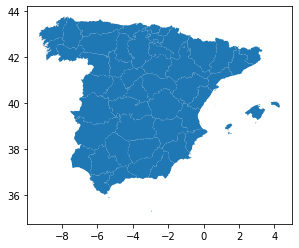

In [ ]:
provincias_gdf.plot()

In [ ]:
pred_X.reset_index(inplace=True)
output_data = submission_set.merge(network, on='PipeId', how='left')
output_data = output_data.merge(pred_X[['InspectionDate', 'PipeId', 'InspectionYear', 'MonthsLastRev']], on=['PipeId'], how='left')
# set indexes again to be able to re-run the model straight away
pred_X = pred_X.set_index(['PipeId', 'InspectionDate'])

output_data

,PipeId,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,InspectionDate,InspectionYear,MonthsLastRev
0,446859944,0.118694,Valencia,Alginet,2012,PE,Gas natural,110.0,44.286,0.150,0,0,False,2022-12-31,2022,24
1,428124500,0.455494,Valencia,Alginet,2012,PE,Gas natural,160.0,110.715,0.150,2,0,False,2020-11-10,2020,22
2,438428871,0.120122,Valencia,Alginet,2012,PE,Gas natural,110.0,13.575,0.150,0,0,False,2022-12-31,2022,24
3,429034569,0.798211,Valencia,Alginet,2012,PE,Gas natural,110.0,327.689,0.150,3,0,False,2022-12-31,2022,24
4,411184477,0.282385,Valencia,Alginet,2007,PE,Gas natural,200.0,932.762,0.150,0,0,False,2022-12-31,2022,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,235426649,0.066816,Valencia,Paterna,2004,PE,Gas natural,110.0,7.656,0.025,0,0,False,2021-11-16,2021,22
909729,235426673,0.334753,Valencia,Paterna,2004,PE,Gas natural,110.0,4.383,0.025,2,0,False,2021-11-16,2021,22
909730,235426707,0.244224,Valencia,Paterna,2004,PE,Gas natural,110.0,2.292,0.025,1,0,False,2021-08-16,2021,19
909731,190956601,0.119138,Valencia,Paterna,2004,PE,Gas natural,90.0,87.809,4.000,0,0,False,2021-12-03,2021,23


In [ ]:
mean_prob_provinces = output_data.groupby('Province').mean().Incidence
mean_prob_provinces = pd.DataFrame(mean_prob_provinces)
mean_prob_provinces.reset_index(inplace=True)
mean_prob_provinces

,Province,Incidence
0,Albacete,0.140008
1,Alicante,0.199281
2,Almeria,0.169133
3,Avila,0.445775
4,Barcelona,0.290127
5,Burgos,0.246728
6,Castellón,0.246692
7,Ciudad Real,0.293018
8,Cuenca,0.363849
9,Cádiz,0.210738


In [ ]:
provincias_gdf = provincias_gdf.merge(mean_prob_provinces, left_on=['NAMEUNIT'],right_on=['Province'], how='left')
provincias_gdf = provincias_gdf.drop(['Province'], axis=1)
provincias_gdf

,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,geometry,Incidence
0,Alava,ES2,ES21,NaN,"POLYGON ((-2.76808 42.61408, -2.76863 42.61334...",NaN
1,Albacete,ES4,ES42,NaN,"POLYGON ((-2.55212 38.08501, -2.55207 38.08517...",0.140008
2,Alicante,ES5,ES52,NaN,"MULTIPOLYGON (((-0.75223 37.88691, -0.75225 37...",0.199281
3,Almería,ES6,ES61,NaN,"MULTIPOLYGON (((-3.03624 35.93791, -3.03637 35...",NaN
4,Avila,ES4,ES41,NaN,"POLYGON ((-5.43382 40.24491, -5.43430 40.24276...",0.445775
5,Badajoz,ES4,ES43,NaN,"POLYGON ((-6.81290 38.12594, -6.81314 38.12621...",NaN
6,Illes Balears,ES5,ES53,NaN,"MULTIPOLYGON (((1.24355 38.86118, 1.24360 38.8...",NaN
7,Barcelona,ES5,ES51,NaN,"MULTIPOLYGON (((1.75125 41.21822, 1.75106 41.2...",0.290127
8,Burgos,ES4,ES41,NaN,"MULTIPOLYGON (((-3.96817 41.58462, -3.96879 41...",0.246728
9,Cáceres,ES4,ES43,NaN,"POLYGON ((-6.80634 39.39066, -6.80690 39.39081...",NaN


<AxesSubplot:>

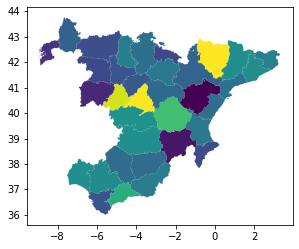

In [ ]:
provincias_gdf.plot(column = 'Incidence')

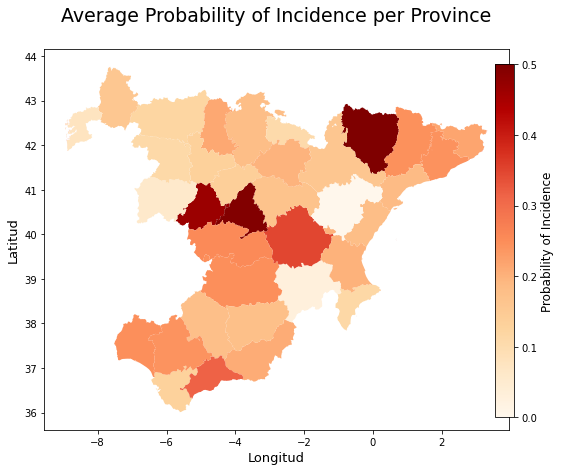

In [ ]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)
#Título del mapa
title = 'Average Probability of Incidence per Province'
#Impresión del título indicando un renglón entre la figura y el #texto
plt.title(title + '\n', fontsize=19)
#Impresión del mapa indicando qué marco(ax) debe tomar de referencia
provincias_gdf.plot(column='Incidence', cmap='OrRd', ax = ax)
#Nombre de los ejes horizontal y vertical
ax.set_xlabel('Longitud', fontsize = 13)
ax.set_ylabel('Latitud', fontsize = 13)
#Definición de los valores mínimo y máximo como límites de la barra #a utilizar
min_p = 0
max_p = 0.5
#Definición de la barra gráfica
bar = plt.cm.ScalarMappable(cmap='OrRd', 
norm=plt.Normalize(vmin = min_p , vmax=max_p))
#Se declara una lista donde se guardarán los valores de la barra
bar._A = []
#Declaración de la ubicación y el tamaño de la barra.
cax = plt.axes([0.85, 0.15, 0.03, 0.7]) #[xcoord, ycoord, ancho, largo]
# Impresión de la barra con las variables superiores (bar y cax)
cbar = fig.colorbar(bar, cax=cax)
#Título de la barra
cbar.set_label('Probability of Incidence', fontsize = 12)

In [ ]:
output_data[output_data['Province']=='Madrid'].sort_values('InspectionDate')

,PipeId,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,InspectionDate,InspectionYear,MonthsLastRev
819705,186671462,0.931472,Madrid,Madrid,1993,PE,Gas natural,200.0,48.426,0.025,6,0,False,2013-03-18,2013,24
744645,190628522,0.759839,Madrid,Arganda del Rey,1997,PE,Gas natural,63.0,94.387,4.000,6,0,False,2013-03-23,2013,25
778803,187754740,0.946848,Madrid,Madrid,1990,FD,Gas natural,200.0,79.755,0.025,6,0,True,2013-04-05,2013,24
721524,190245782,0.985052,Madrid,Madrid,2022,PN,Gas natural,160.0,2.299,0.025,1,0,True,2013-06-01,2013,26
728552,425009077,0.616464,Madrid,Madrid,2011,PE,Gas natural,160.0,0.698,0.025,0,0,False,2013-09-02,2013,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874444,48092147,0.523133,Madrid,Madrid,1988,FD,Gas natural,200.0,3.917,0.025,0,0,True,2023-09-18,2023,39
792854,49128490,0.765078,Madrid,Rivas-Vaciamadrid,1988,AO,Gas natural,38.1,4.065,4.000,0,0,True,2023-10-15,2023,42
752480,54102647,0.299798,Madrid,Madrid,2000,PE,Gas natural,160.0,3.336,0.025,0,0,False,2023-10-16,2023,42
814471,49477115,0.626791,Madrid,Rivas-Vaciamadrid,2004,PE,Gas natural,63.0,3.967,4.000,1,0,False,2023-12-21,2023,43


In [ ]:
inspections[inspections['PipeId']==186671462]

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence
211433,186671462,ZRV-00003764,2011,2011-03-18,132,3,1
